# A minor subsampling comparison

For a arbitrarily chosen snapshot of our warming run, we compare the histogram of cloud top heights for different subsampling methods. 1000 subsamples (out of 11792076 cells, i.e. every 11,792th point) seem to be roughly sufficient for a consistent representation in the histogram, with slightly better results for spatially equally spaced samples. Note that the cell numbering in our regional grid does not support the convenient $4^n$ [subsampling we can use on the global ICON grid](https://easy.gems.dkrz.de/Processing/playing_with_triangles/grid_index_ordering.html). The computing time scales linear with the number of samples.

If we compare timeseries of spatially averaged subsampled datasets, we see that the error (i.e. the discrepancy to the mean of the whole dataset) approaches zero with only a few thousand samples.  

## Comparing histograms of *random* subsampling

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import file_handling as fh
import postprocessing as pp
import calculations as cc
import xarray as xr

def list_files(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    kind = '3D'
    return fh.disk_data_from_keywords(exp_dir, [kind, 'DOM01'], return_file_list=1)

def load_files(file_list):
    data = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")
    data = pp.clean_volume_data(data)
    data = data.expand_dims(exp=['warming'])
    # data = add_control(data)
    data = pp.replace_height_indices_with_values(data)
    data = pp.add_grid(data, clean=0, drop_vars=0)
    return data

def add_control(input_data):
    datasets = list()
    for kind in ['3D_DOM']:
        data = fh.eureca_data_from_keywords([kind, 'DOM01'])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=['control'])
    data = data.drop_vars('height_bnds')
    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')
    return data

def calculate_metrics(data, drop_vars=True, n_subsamples=1000):
    data_vars = list(data)
    data = pp.random_subsample(data, {'cell':n_subsamples}).squeeze()
    data = cc.add_lifting_condensation_level_pressure(data)
    data = cc.add_lower_tropospheric_stability(data)
    data = cc.add_estimated_lapse_rate_stability(data)
    data = cc.add_cloud_top_height(data)
    data = data.compute()
    if drop_vars: data = data.drop_vars(data_vars)
    return data

In [2]:
pp.random_subsample?

Signature: pp.random_subsample(dataset, dim_samples)
Docstring:
Takes a random subsample along specified dimensions in an xarray.Dataset.

Parameters:
- dataset (xarray.Dataset): The input dataset.
- dim_samples (dict): A dictionary where keys are dimension names and values are the number of random samples to select.

Returns:
- xarray.Dataset: A new dataset containing only the randomly selected subsamples along the specified dimensions.
File:      ~/warm_eurec4a/submodules/postprocessing.py
Type:      function

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 96 times more chunks
  return self.array[key]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 189 times more chunks
  return self.array[key]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 373 times more chunks
  return self.array[key]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.

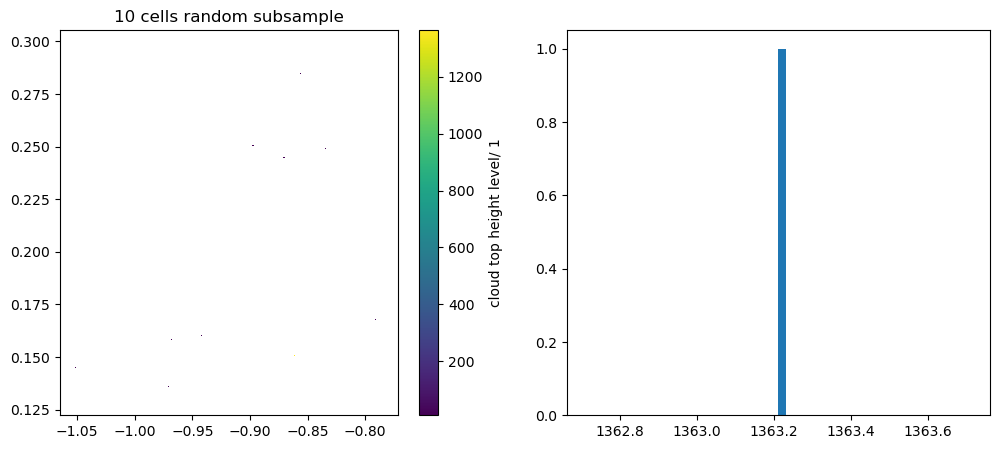

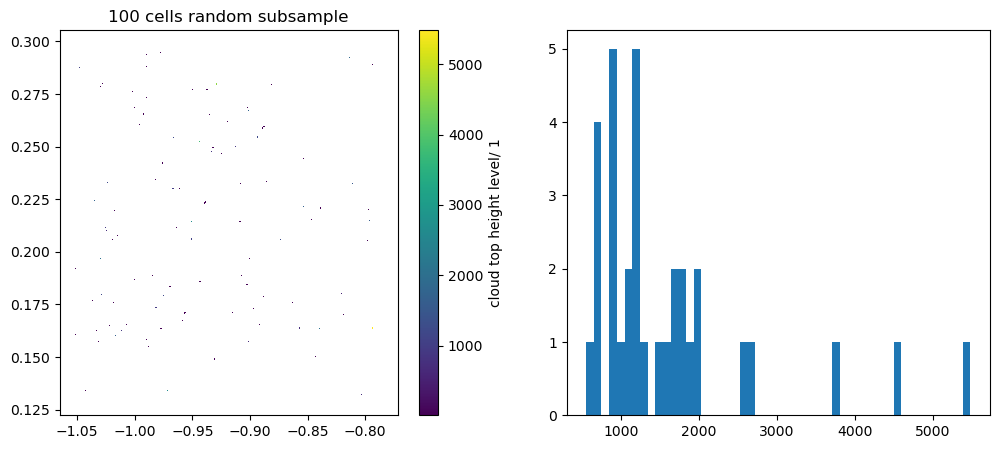

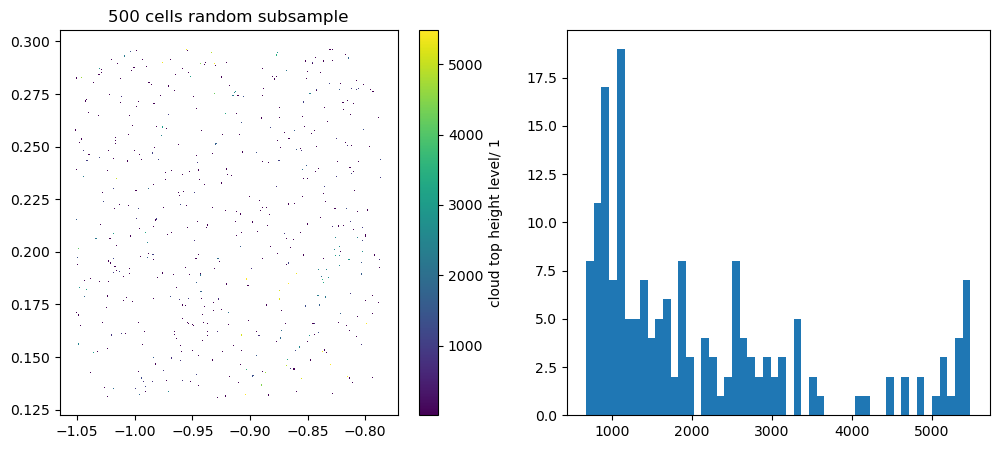

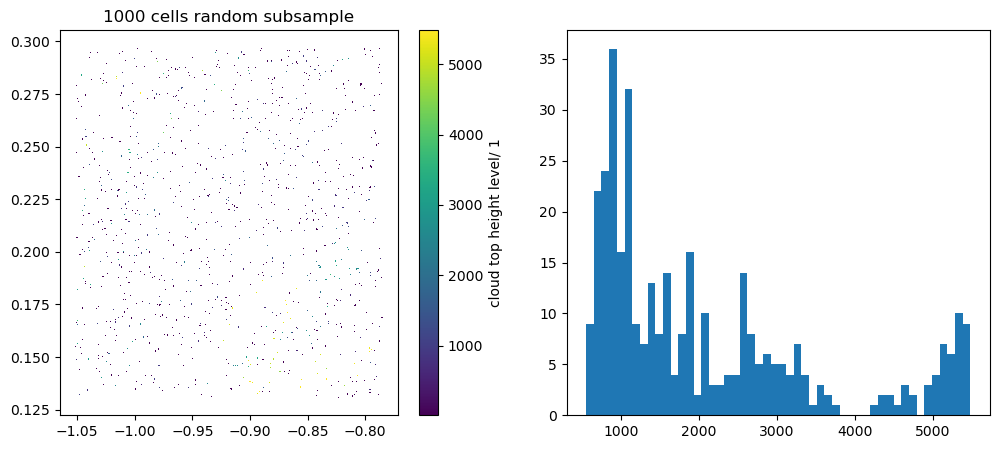

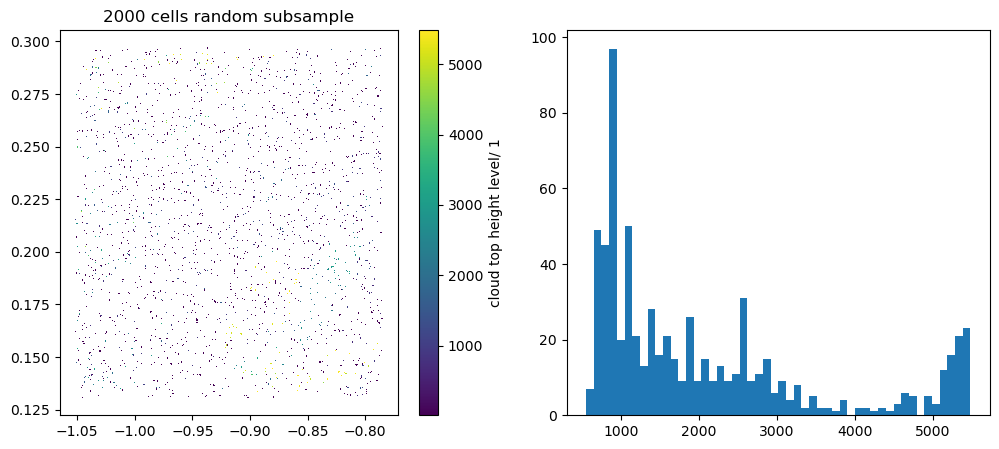

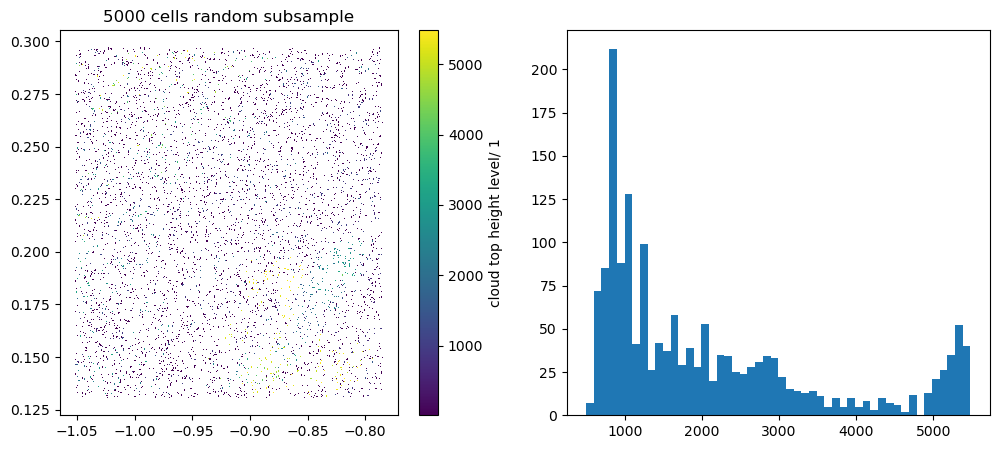

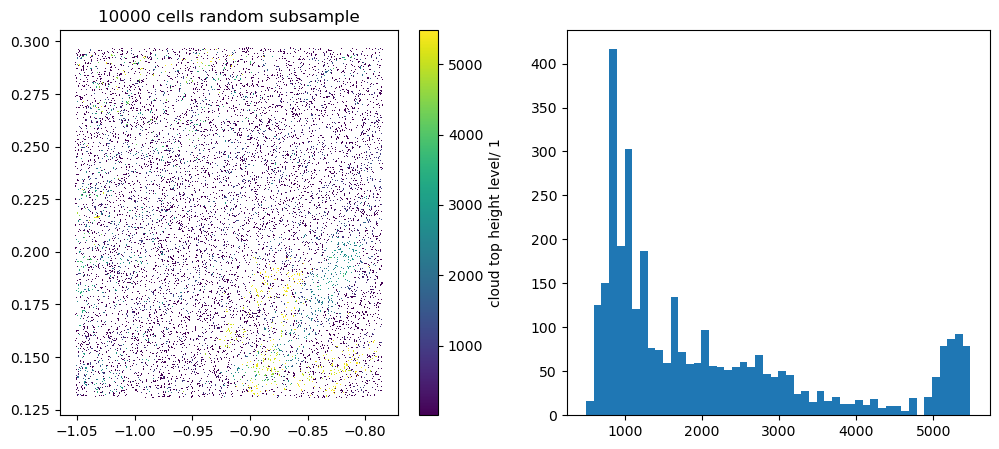

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import plot_utils as pu

def fig_subsampled_variable(var, n_subsamples):
    ifile = list_files()
    ifile = ifile[100]
    data = load_files(ifile)
    data = calculate_metrics(data, drop_vars=False, n_subsamples=n_subsamples)
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    ax = axs[0]
    ax = pu.ax_triangles(ax, data, var)
    ax.set_title(f'{n_subsamples} cells random subsample')
    ax = axs[1]
    values = data[var].values
    values[values == 10.] = None
    ax = ax.hist(values, bins=50)
    return fig, axs

for n in [10,100, 500, 1000, 2000, 5000, 10000]:
    fig, axs = fig_subsampled_variable('cth', n)

## Comparing Histograms of *regular* subsampling

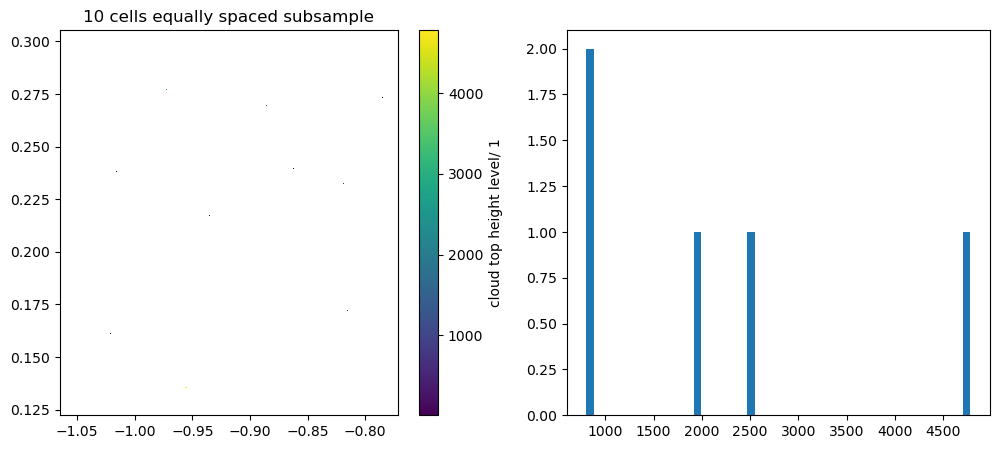

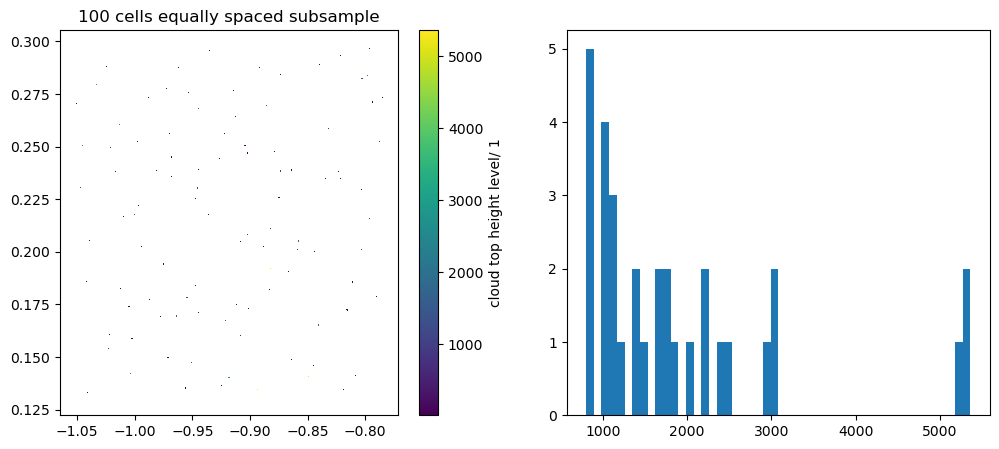

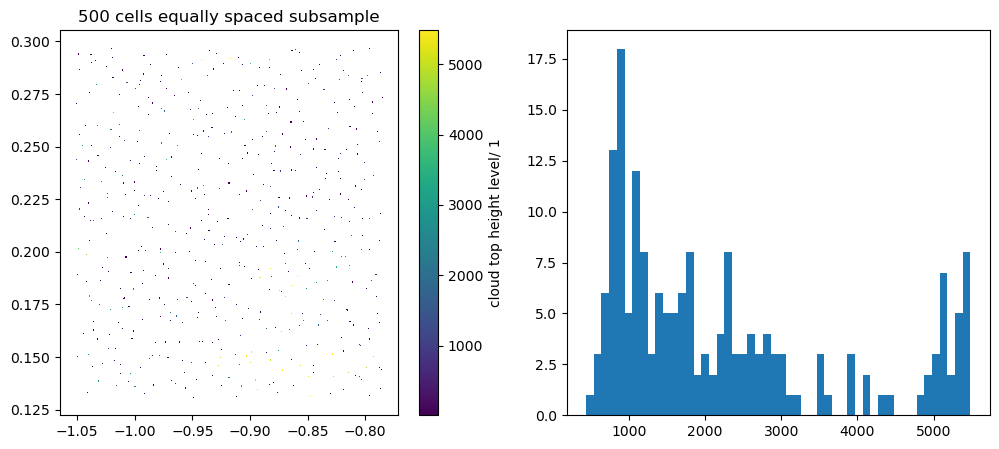

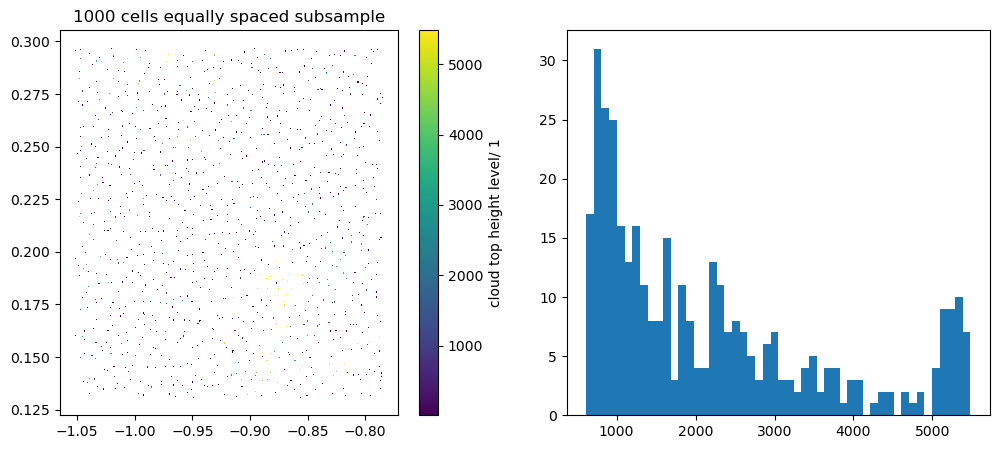

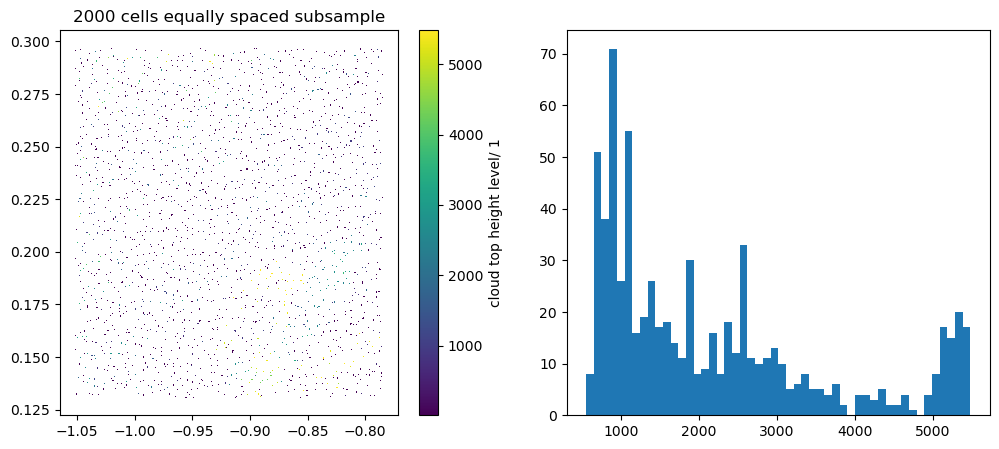

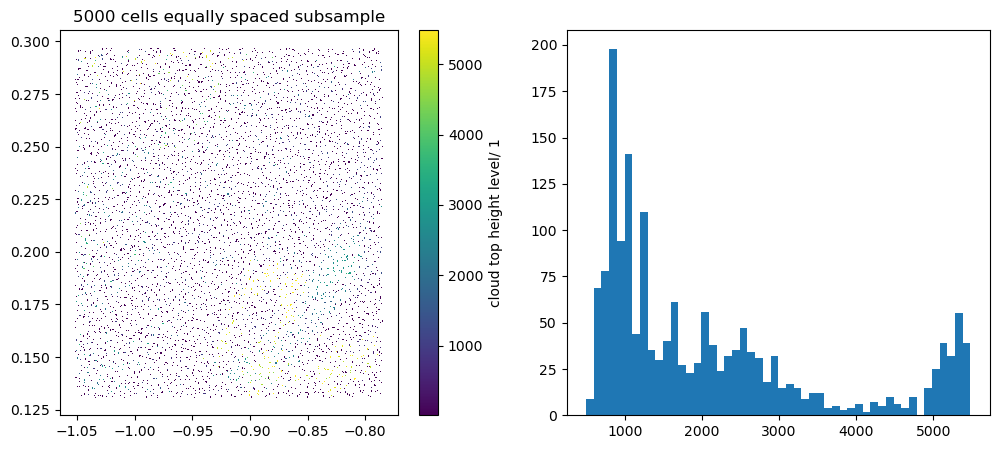

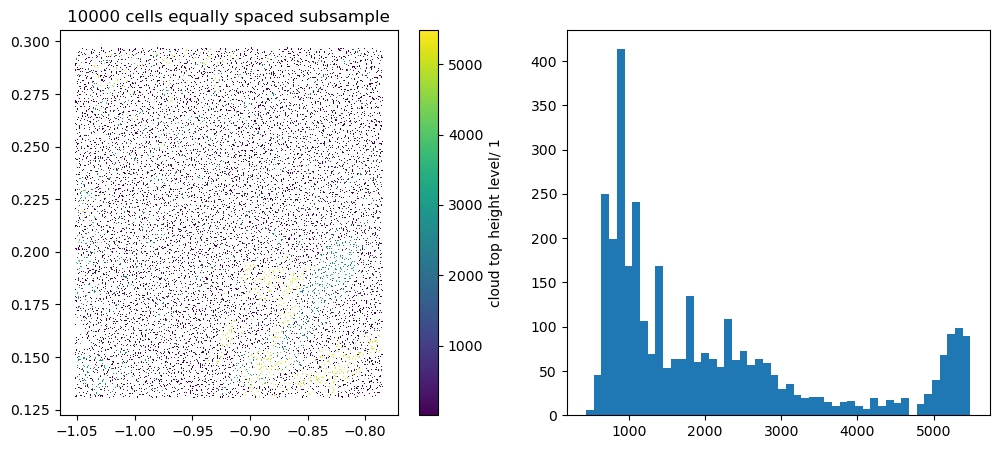

In [4]:
def regular_subsample(dataset, dim_samples):
    """
    Takes an equally spaced subsample along specified dimensions in an xarray.Dataset.

    Parameters:
    - dataset (xarray.Dataset): The input dataset.
    - dim_samples (dict): A dictionary where keys are dimension names and values are the number of samples to select.

    Returns:
    - xarray.Dataset: A new dataset containing only the equally spaced selected subsamples along the specified dimensions.
    """
    for dim, n_samples in dim_samples.items():
        if n_samples > dataset[dim].size:
            raise ValueError(f"n_samples ({n_samples}) for '{dim}' is greater than the size of the dimension ({dataset[dim].size}).")
        step_size = max(1, np.floor(dataset[dim].size / n_samples).astype(int))
        indices = np.arange(0, dataset[dim].size, step_size)[:n_samples]
        selection = dataset[dim][indices]
        dataset = dataset.sel({dim: selection})
    return dataset 

def calculate_metrics(data, drop_vars=True, n_subsamples=1000):
    data_vars = list(data)
    data = regular_subsample(data, {'cell':n_subsamples}).squeeze()
    data = cc.add_lifting_condensation_level_pressure(data)
    data = cc.add_lower_tropospheric_stability(data)
    data = cc.add_estimated_lapse_rate_stability(data)
    data = cc.add_cloud_top_height(data)
    data = data.compute()
    if drop_vars: data = data.drop_vars(data_vars)
    return data

def fig_subsampled_variable(var, n_subsamples):
    ifile = list_files()
    ifile = ifile[100]
    data = load_files(ifile)
    data = calculate_metrics(data, drop_vars=False, n_subsamples=n_subsamples)
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    ax = axs[0]
    ax = pu.ax_triangles(ax, data, var)
    ax.set_title(f'{n_subsamples} cells equally spaced subsample')
    ax = axs[1]
    values = data[var].values
    values[values == 10.] = None
    ax = ax.hist(values, bins=50)
    return fig, axs

for n in [10,100, 500, 1000, 2000, 5000, 10000]:
    fig, axs = fig_subsampled_variable('cth', n)

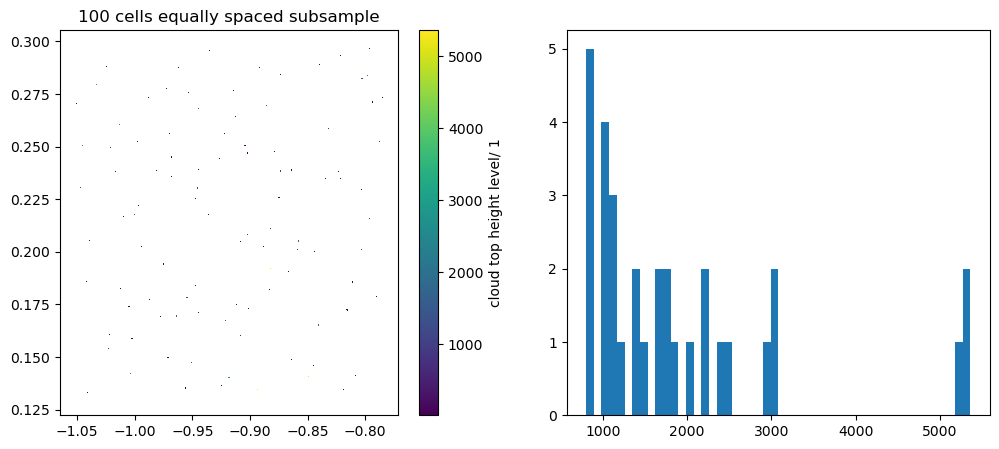

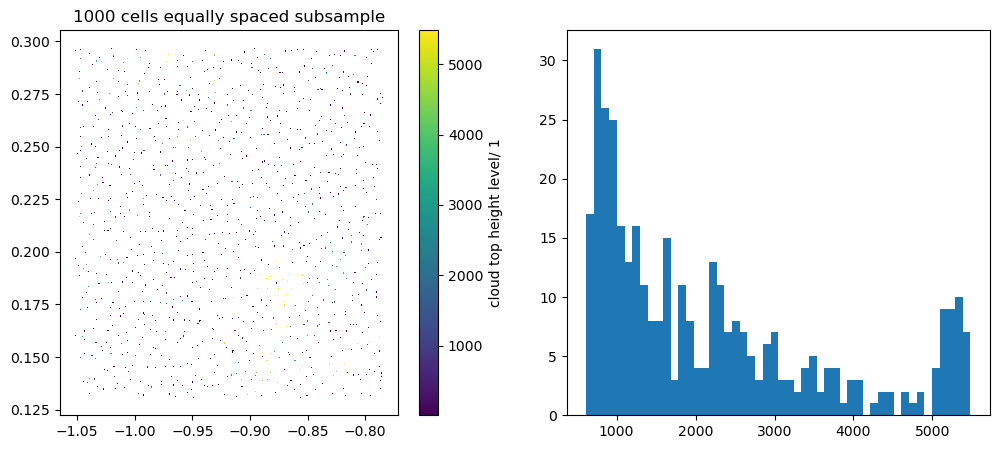

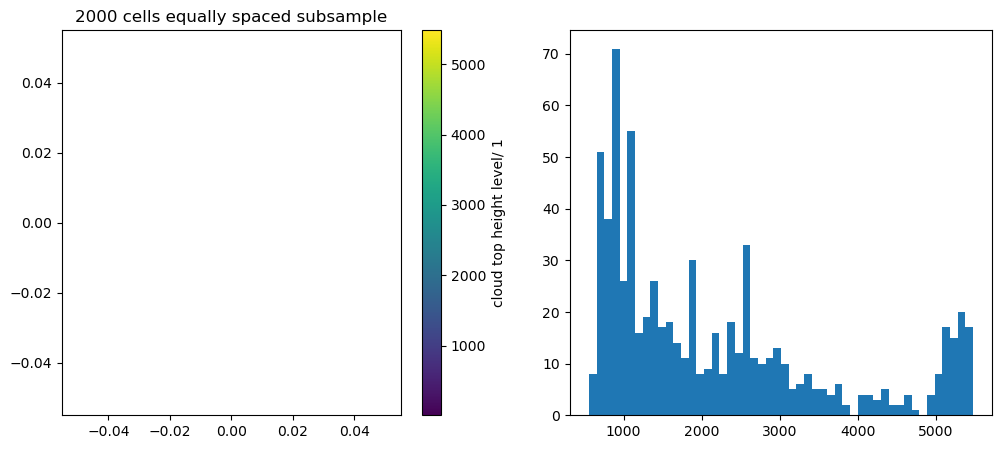

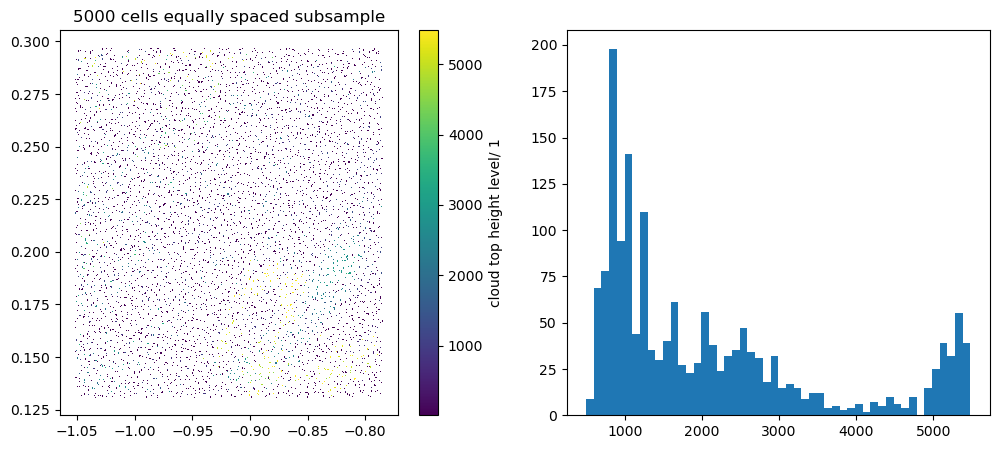

In [5]:
def fig_subsampled_variable(var, n_subsamples):
    ifile = list_files()
    ifile = ifile[100]
    data = load_files(ifile)
    data = calculate_metrics(data, drop_vars=False, n_subsamples=n_subsamples)
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    ax = axs[0]
    ax = pu.ax_triangles(ax, data, var)
    ax.set_title(f'{n_subsamples} cells equally spaced subsample')
    ax = axs[1]
    values = data[var].values
    values[values == 10.] = None
    ax = ax.hist(values, bins=50)
    return fig, axs

for n in [100, 1000, 2000, 5000]:
    fig, axs = fig_subsampled_variable('cth', n)

## Direct comparison and computing cost analysis

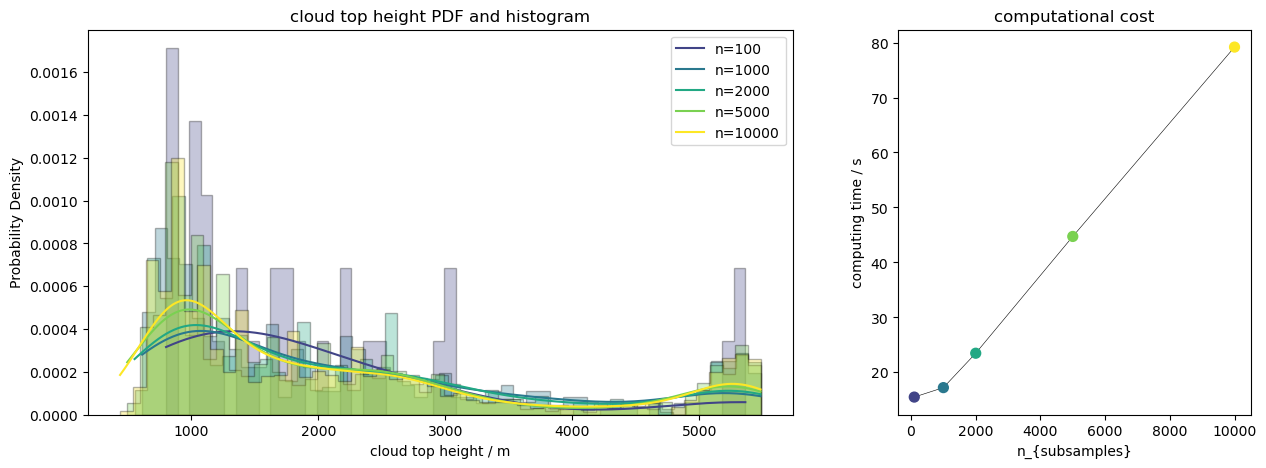

In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.stats
import time

datasets, labels, colors = list(), list(), list()
times = dict()  # List to store computation times

for n in [100, 1000, 2000, 5000, 10000]:
    start_time = time.time()  # Start timing
    ifile = list_files()
    ifile = ifile[100]
    data = load_files(ifile)
    data = calculate_metrics(data, drop_vars=False, n_subsamples=n)
    end_time = time.time()  # End timing
    
    datasets.append(data)
    labels.append(str(n))
    times[n] = (end_time - start_time)  # Calculate and store the time taken

cmap = matplotlib.cm.get_cmap('viridis')
for i in range(len(labels)):
    colors.append(cmap((i+1)/len(labels)))


fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(15,5))
ax, ax2 = axs

hist_kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=50, ec="k")
for data, label, color in zip(datasets, labels, colors):
    data = data['cth'].values.flatten()  # Convert to a 1D NumPy array
    data[data == 10.] = np.nan 
    data = data[~np.isnan(data)]
    
    kde = scipy.stats.gaussian_kde(data)
    x_range = np.linspace(np.min(data), np.max(data), 1000)
    pdf_values = kde(x_range)
    
    ax.hist(data, color=color, **hist_kwargs)
    ax.plot(x_range, pdf_values, label=f'n={label}', color=color)

ax.legend()
ax.set_title('cloud top height PDF and histogram')
ax.set_xlabel('cloud top height / m')
ax.set_ylabel('Probability Density')

# New plot for number of subsamples vs. time to compute

ax2.plot(times.keys(), times.values(), color='#000000', lw=.4)
ax2.scatter(times.keys(), times.values(), marker='o', color=colors, s=50, zorder=2.5)
ax2.set_title('computational cost')
ax2.set_xlabel(r'n_{subsamples}')
ax2.set_ylabel('computing time / s')

plt.show()

## Mean square error of subsampled time series

In [24]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
    
import xarray as xr
import numpy as np
import matplotlib.cm
import file_handling as fh
fh.disable_warnings(False)
import postprocessing as pp
import calculations as cc

def load_files(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', kind='surface'):
    data = fh.disk_data_from_keywords(exp_dir, [kind, 'DOM01'])
    data = pp.clean_surface_data(data)
    data = data.sortby('time')
    return data

var = 'clct'
datasets = dict()
colors = list()
error = dict()

for n in [100, 1000, 2000, 5000]:
# for n in [100, 200]: 
    data = load_files()
    data = pp.random_subsample(data, {'cell':n}).squeeze()
    data = data[var].mean(dim='cell', keep_attrs=True)
    datasets[n] = data
    error[n] = ((data - full_data) ** 2).mean(dim='time').values

cmap = matplotlib.cm.get_cmap('viridis')
for i in range(len(datasets)):
    colors.append(cmap((i+1)/len(datasets)))

In [25]:
full_data = load_files()[var].mean(dim='cell')

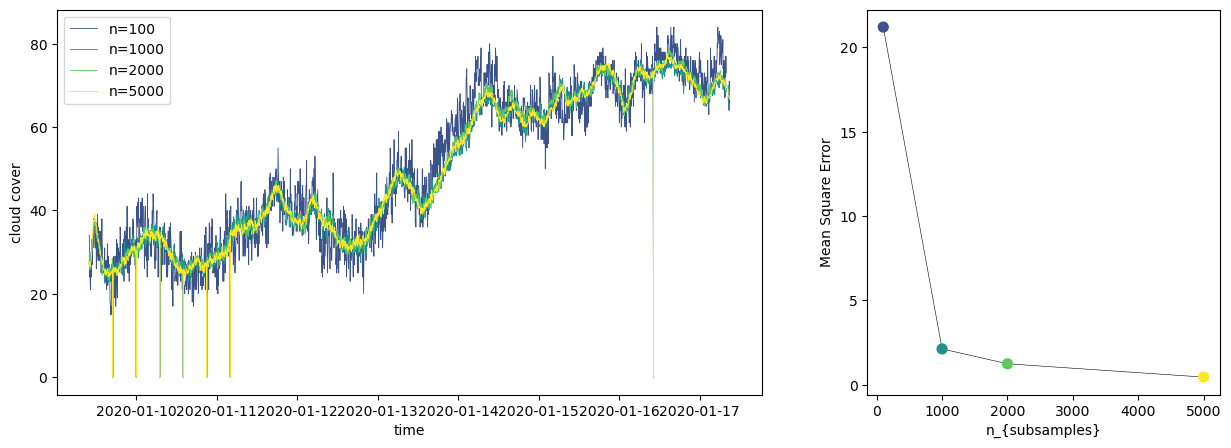

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(15,5))
ax1, ax2 = axs

for data, label, color in zip(datasets.values(), datasets.keys(), colors):
    ax1.plot(data.time.values, data.values, label=f'n={str(label)}', color=color, lw=.6)
ax1.set_xlabel('time')
ax1.set_ylabel('cloud cover')
ax1.legend()

ax2.plot(error.keys(), error.values(), color='#000000', lw=.4)
ax2.scatter(error.keys(), error.values(), marker='o', color=colors, s=50, zorder=2.5)
# ax2.set_title('')
ax2.set_xlabel(r'n_{subsamples}')
ax2.set_ylabel('Mean Square Error')

# fig.title('Comparison of Subsample Sizes and MSE')
fig.show()